In [346]:
import pandas as pd
import numpy as np

### Import dataset

In [347]:
df = pd.read_csv('./datasets/house_prices.csv', encoding='utf-8-sig')
df.shape

(15327, 17)

In [348]:
# rename columns
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['title', 'sub_title', 'price', 'address', 'baths', 'land_size', 'beds',
       'house_size', 'location', 'description', 'post_url', 'seller_name',
       'seller_type', 'published_date', 'geo_address', 'lat', 'lon'],
      dtype='object')

In [349]:
df.head(3)

,title,sub_title,price,address,baths,land_size,beds,house_size,location,description,post_url,seller_name,seller_type,published_date,geo_address,lat,lon
0,House with Land for Sale in Matara for sale,"Posted on 06 Nov 2:32 pm, Matara City, Matara","Rs 5,400,000","Gangodagama Roard,Hakmana,Matara.",1,50.0 perches,3,"1,600.0 sqft","Matara City, Matara","Land for sale with house Matara,Hakmana Gangod...",https://ikman.lk/en/ad/house-with-land-for-sal...,Ishara Dilshan,Member,2021-11-06 14:32:00,"Matara City, Matara, Sri Lanka",80.500000,6.166670
1,à¶ à¶½à·à¶­à· à¶à·à¶¸à¶» 3 à¶ à¶à·à· à...,"Posted on 24 Oct 7:27 am, Athurugiriya, Colombo","Rs 16,800,000",Athurugiriya Galwarusapare,3,8.0 perches,3,"1,480.0 sqft","Athurugiriya, Colombo",*House For Sale In Athurugiriya *Galwarusapare...,https://ikman.lk/en/ad/alut-kaamr-3-k-grh-bhaa...,DILRUWAN REAL ESTATE,Premium-Member,2021-10-24 07:27:00,"Athurugiriya, Colombo, Sri Lanka",79.989929,6.877246
2,Kelaniya - House on 20P Land for sale for sale,"Posted on 17 Nov 5:19 pm, Kelaniya, Gampaha","Rs 20,000,000",Kelaniya- Ranaviru Maldeniya Road,2,20.0 perches,3,"2,800.0 sqft","Kelaniya, Gampaha","Kelaniya- Biyagama road, Ranaviru Maladeniya R...",https://ikman.lk/en/ad/kelaniya-house-on-20p-l...,Provident Paradise (Pvt) Ltd,Member,2021-11-17 17:19:00,"Kelaniya, Gampaha, Sri Lanka",79.914926,6.951178


In [350]:
# switch lat and lon columns since they are switched
df = df.rename(columns={'lat': 'lon', 'lon': 'lat'})

 ### Remove irrelevant attributes

The dataset contains platform specific attributes, which does not fit into the general model
- title - title of the post
- sub_title - subtitle of the post
- post_url - url of the post
- seller_name - name of the seller
- seller_type - type of the seller
- description - description of the post

In [351]:
df = df.drop(columns=['title', 'sub_title', 'post_url', 'seller_name', 'seller_type', 'description'], errors='ignore')
df.shape

(15327, 11)

In [352]:
df = df.drop(columns=['location', 'address'])

### Remove redundant attributes
Address, location and geo_address contain the same information. Remove address and location since geo_address is more structured

In [353]:
df = df.drop(columns=['location'], errors='ignore')
df.shape

(15327, 9)

### remove missing values and duplicates

In [354]:
print('missing values:\n', df.isna().sum(), sep='')

# drop rows with missing values
df = df.dropna()


missing values:
price             0
baths             0
land_size         0
beds              0
house_size        0
published_date    0
geo_address       0
lon               0
lat               0
dtype: int64


In [355]:
print('duplicated rows:', df.duplicated().sum())

# drop duplicated rows
df.drop_duplicates(inplace=True)

duplicated rows: 691


In [356]:
df.head()

,price,baths,land_size,beds,house_size,published_date,geo_address,lon,lat
0,"Rs 5,400,000",1,50.0 perches,3,"1,600.0 sqft",2021-11-06 14:32:00,"Matara City, Matara, Sri Lanka",80.500000,6.166670
1,"Rs 16,800,000",3,8.0 perches,3,"1,480.0 sqft",2021-10-24 07:27:00,"Athurugiriya, Colombo, Sri Lanka",79.989929,6.877246
2,"Rs 20,000,000",2,20.0 perches,3,"2,800.0 sqft",2021-11-17 17:19:00,"Kelaniya, Gampaha, Sri Lanka",79.914926,6.951178
3,"Rs 187,000,000",5,22.0 perches,5,"4,000.0 sqft",2021-11-17 17:07:00,"Colombo 6, Colombo, Sri Lanka",80.016670,6.866670
4,"Rs 1,300,000",1,6.3 perches,2,900.0 sqft,2021-11-17 17:06:00,"Dehiwala, Colombo, Sri Lanka",79.880242,6.838232


### Concept hierarchy generation

use geo_address to generate a concept hierarchy for the location attribute
- level 1: country
- level 2: district
- level 3: city

In [357]:
df[['city', 'district', 'country']] = df['geo_address'].str.lower().str.split(',', n=2, expand=True).apply(lambda x: x.str.strip())
df = df.drop(columns=['geo_address'], errors='ignore')

countries = df['country'].unique()
districts = df['district'].unique()
cities = df['city'].unique()

print(f'countries ({len(countries)}): {countries[:5]}')
print(f'districts ({len(districts)}): {districts[:5]}')
print(f'cities ({len(cities)}): {cities[:5]}')

countries (1): ['sri lanka']
districts (24): ['matara' 'colombo' 'gampaha' 'kandy' 'jaffna']
cities (172): ['matara city' 'athurugiriya' 'kelaniya' 'colombo 6' 'dehiwala']


In [358]:
# remove country column since all values are sri lanka
df = df.drop(columns=['country'], errors='ignore')

### Data type conversion and unit conversion

#### processing price, house_size and land_size

In [359]:
# split units and values

temp_df = pd.DataFrame()

temp_df[['price_unit','price']] = df['price'].str.split(' ', n=1, expand=True)
temp_df[['house_size', 'house_size_unit']] = df['house_size'].str.split(' ', n=1, expand=True)
temp_df[['land_size', 'land_size_unit']] = df['land_size'].str.split(' ', n=1, expand=True)

temp_df.head()


,price_unit,price,house_size,house_size_unit,land_size,land_size_unit
0,Rs,"5,400,000","1,600.0",sqft,50.0,perches
1,Rs,"16,800,000","1,480.0",sqft,8.0,perches
2,Rs,"20,000,000","2,800.0",sqft,20.0,perches
3,Rs,"187,000,000","4,000.0",sqft,22.0,perches
4,Rs,"1,300,000",900.0,sqft,6.3,perches


In [360]:
# remove commas
temp_df['price'] = temp_df['price'].str.replace(',', '')
temp_df['house_size'] = temp_df['house_size'].str.replace(',', '')
temp_df['land_size'] = temp_df['land_size'].str.replace(',', '')

# convert to numeric
temp_df['price'] = pd.to_numeric(temp_df['price'])
temp_df['house_size'] = pd.to_numeric(temp_df['house_size'])
temp_df['land_size'] = pd.to_numeric(temp_df['land_size'])

temp_df.head()

,price_unit,price,house_size,house_size_unit,land_size,land_size_unit
0,Rs,5400000,1600.0,sqft,50.0,perches
1,Rs,16800000,1480.0,sqft,8.0,perches
2,Rs,20000000,2800.0,sqft,20.0,perches
3,Rs,187000000,4000.0,sqft,22.0,perches
4,Rs,1300000,900.0,sqft,6.3,perches


In [361]:
# analyze units
print('price', temp_df['price_unit'].unique())
print('house_size', temp_df['house_size_unit'].unique())
print('land_size', temp_df['land_size_unit'].unique())

price ['Rs']
house_size ['sqft']
land_size ['perches' 'acres']


In [362]:
# convert acres to perches
temp_df.loc[temp_df['land_size_unit'] == 'acres', 'land_size'] = temp_df['land_size'] * 160

temp_df.head()

,price_unit,price,house_size,house_size_unit,land_size,land_size_unit
0,Rs,5400000,1600.0,sqft,50.0,perches
1,Rs,16800000,1480.0,sqft,8.0,perches
2,Rs,20000000,2800.0,sqft,20.0,perches
3,Rs,187000000,4000.0,sqft,22.0,perches
4,Rs,1300000,900.0,sqft,6.3,perches


In [363]:
# processed values to original dataframe
df[['price', 'house_size', 'land_size']] = temp_df[['price', 'house_size', 'land_size']]

del temp_df

df[['price', 'house_size', 'land_size']].head()


,price,house_size,land_size
0,5400000,1600.0,50.0
1,16800000,1480.0,8.0
2,20000000,2800.0,20.0
3,187000000,4000.0,22.0
4,1300000,900.0,6.3


#### processing beds and baths

In [364]:
# find non numeric values

beds_non_numeric_mask = ~df['beds'].str.isnumeric()
baths_non_numeric_mask = ~df['baths'].str.isnumeric()

print('beds: ', df[beds_non_numeric_mask]['beds'].unique())
print('baths: ', df[baths_non_numeric_mask]['baths'].unique())

beds:  ['10+']
baths:  ['10+']


In [365]:
# replace x+ with x + 1
df.loc[beds_non_numeric_mask, 'beds'] = df.loc[beds_non_numeric_mask, 'beds'].str.replace('+', '').astype('int') + 1
df.loc[baths_non_numeric_mask, 'baths'] = df.loc[baths_non_numeric_mask, 'baths'].str.replace('+', '').astype('int') + 1

# convert to numeric
df['beds'] = pd.to_numeric(df['beds'], downcast='integer')
df['baths'] = pd.to_numeric(df['baths'], downcast='integer')

print('beds: ', df['beds'].unique())
print('baths: ', df['baths'].unique())

beds:  [ 3  5  2  4 11  9  8  6  7  1 10]
baths:  [ 1  3  2  5  4 11  7  6  8 10  9]


#### processing published_date

In [366]:
df['published_date'].head()

0    2021-11-06 14:32:00
1    2021-10-24 07:27:00
2    2021-11-17 17:19:00
3    2021-11-17 17:07:00
4    2021-11-17 17:06:00
Name: published_date, dtype: object

In [367]:
df['published_date'] = pd.to_datetime(df['published_date'], format='%Y-%m-%d %H:%M:%S')
df['published_date'].head()

0   2021-11-06 14:32:00
1   2021-10-24 07:27:00
2   2021-11-17 17:19:00
3   2021-11-17 17:07:00
4   2021-11-17 17:06:00
Name: published_date, dtype: datetime64[ns]

### Outlier detection

In [368]:
# generate features for outlier detection

temp_df = df.copy()

temp_df['price_per_land_size'] = df['price'] / df['land_size']
temp_df['price_per_house_size'] = df['price'] / df['house_size']
temp_df['baths_per_bed'] = df['baths'] / df['beds']
temp_df['sqft_per_bed'] = df['house_size'] / df['beds']

#### Using domain knowledge for outlier detection

In [369]:
# houses with 0 values for beds, land_size, house_size
zero_values_mask = (df['beds'] == 0) | (df['land_size'] == 0) | (df['house_size'] == 0)

# houses with less than 5 perches
land_size_mask = df['land_size'] < 5

# houses with less than 100 sqft per bed or more than 1000 sqft per bed
sqft_per_bed_mask = (temp_df['sqft_per_bed'] < 100) | (temp_df['sqft_per_bed'] > 1000)

# houses with more than 1.5 bath per bed
baths_per_bed_mask = temp_df['baths_per_bed'] > 1.5

# houses with less than 50,000 LKR per perch
price_per_land_size_mask = temp_df['price_per_land_size'] < 50000

# TODO : lat lon outliers

# print outliers
print('zero values: ', zero_values_mask.sum())
print('land size: ', land_size_mask.sum())
print('sqft per bed: ', sqft_per_bed_mask.sum())
print('baths per bed: ', baths_per_bed_mask.sum())
print('price per land size: ', price_per_land_size_mask.sum())

# combine outlier masks
outlier_mask_dk = zero_values_mask | land_size_mask | sqft_per_bed_mask | baths_per_bed_mask | price_per_land_size_mask
print('\ntotal outliers: ', outlier_mask_dk.sum())


zero values:  5
land size:  388
sqft per bed:  1231
baths per bed:  22
price per land size:  52

total outliers:  1655


In [370]:
# outlier percentage
print(f'outlier percentage: {outlier_mask_dk.sum() / len(df) * 100:.2f}%')

outlier percentage: 11.31%


In [371]:
# drop outliers
df = df[~outlier_mask_dk]
df.shape

(12981, 10)

#### Using Z-score for outlier detection

In [372]:
def detect_outliers(df, threshold, features):
    outlier_mask = None

    for f in features:
        mean = np.mean(df[f])
        std = np.std(df[f])
        abs_z_score = np.abs((df[f] - mean) / std)
        mask = abs_z_score > threshold
        outlier_mask = mask if outlier_mask is None else outlier_mask | mask

    return outlier_mask

# detect outliers using z-score with 2 standard deviations
outlier_mask_zs = detect_outliers(temp_df, 2, ['price_per_land_size', 'price_per_house_size', 'baths_per_bed', 'sqft_per_bed', 'land_size', 'house_size', 'price'])

print('total outliers: ', outlier_mask_zs.sum())

total outliers:  1181


c:\Users\USER\Documents\SLIIT\fdm mini project\.venv\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [373]:
# outlier percentage
print(f'outlier percentage: {outlier_mask_zs.sum() / len(outlier_mask_dk) * 100:.2f}%')

outlier percentage: 8.07%


In [374]:
# drop outliers
df = df[~outlier_mask_zs]
df.shape

C:\Users\USER\AppData\Local\Temp\ipykernel_4668\2140630139.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~outlier_mask_zs]


(12311, 10)

### feature generation

In [375]:
def generate_features(df):
    df['sqft_per_bed'] = df['house_size'] / df['beds']
    df['house_land_ratio'] = df['house_size'] / df['land_size'] / 272.25
    df['baths_per_bed'] = df['baths'] / df['beds']
    
    return df

df = generate_features(df)


### Data Analysis

In [376]:
df.head()

,price,baths,land_size,beds,house_size,published_date,lon,lat,city,district,sqft_per_bed,house_land_ratio,baths_per_bed
0,5400000,1,50.0,3,1600.0,2021-11-06 14:32:00,80.500000,6.166670,matara city,matara,533.333333,0.117539,0.333333
1,16800000,3,8.0,3,1480.0,2021-10-24 07:27:00,79.989929,6.877246,athurugiriya,colombo,493.333333,0.679522,1.000000
2,20000000,2,20.0,3,2800.0,2021-11-17 17:19:00,79.914926,6.951178,kelaniya,gampaha,933.333333,0.514233,0.666667
4,1300000,1,6.3,2,900.0,2021-11-17 17:06:00,79.880242,6.838232,dehiwala,colombo,450.000000,0.524728,0.500000
5,55000000,4,11.0,4,3300.0,2021-11-17 17:04:00,80.016670,6.866670,talawatugoda,colombo,825.000000,1.101928,1.000000


In [377]:
temp_df = df.copy()
temp_df['price_per_house_size'] = temp_df['price'] / temp_df['house_size']

#### correlation analysis

<Axes: title={'center': 'Correlation Heatmap'}>

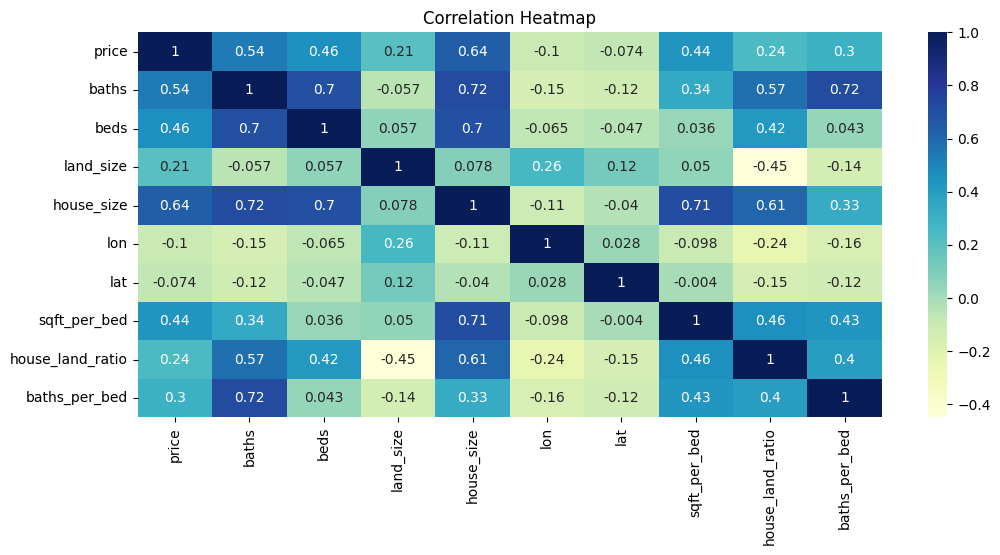

In [378]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['price','baths', 'beds', 'land_size', 'house_size', 'lon', 'lat', 'sqft_per_bed', 'house_land_ratio', 'baths_per_bed']].corr()

plt.figure(figsize=(12,5))
plt.title('Correlation Heatmap')
sns.heatmap(corr, annot=True, cmap='YlGnBu')

The price of the house has a strong positive correlation with the house size, beds and baths concluding that the price of the house increases with the increase of the house size and the number of beds and baths.

The price of the house has a weak positive correlation with the land size. This concludes that the land size is not a major factor in determining the price of the house.

Longitude and latitude has a weak negative correlation with the price of the house. This concludes that the raw location of the house is not a major factor in determining the price of the house.

Also the generated features sqft per bed, house land ratio, baths per bed has a moderately strong positive correlation with the price of the house. This concludes that the price of the house increases with the increase of the sqft per bed, house land ratio and baths per bed.

The correlation between house size, baths and beds is also postive and strong. This concludes that the house size increases with the increase of the number of beds and baths and vice versa.

#### published date analysis

In [379]:
# analyze published date

temp_df['published_year'] = temp_df['published_date'].dt.year
temp_df['published_month'] = temp_df['published_date'].dt.month
temp_df['published_day'] = temp_df['published_date'].dt.day
temp_df['published_hour'] = temp_df['published_date'].dt.hour
temp_df['published_day_of_week'] = temp_df['published_date'].dt.dayofweek

# print unique values
print('published_year: ', sorted(temp_df['published_year'].unique()))
print('published_month: ', sorted(temp_df['published_month'].unique()))
print('published_day: ', sorted(temp_df['published_day'].unique()))
print('published_hour: ', sorted(temp_df['published_hour'].unique()))
print('published_day_of_week: ', sorted(temp_df['published_day_of_week'].unique()))

published_year:  [2021]
published_month:  [9, 10, 11]
published_day:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
published_hour:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
published_day_of_week:  [0, 1, 2, 3, 4, 5, 6]


In [380]:
# drop published_year since all values are 2021
temp_df = temp_df.drop(columns=['published_year'], errors='ignore')

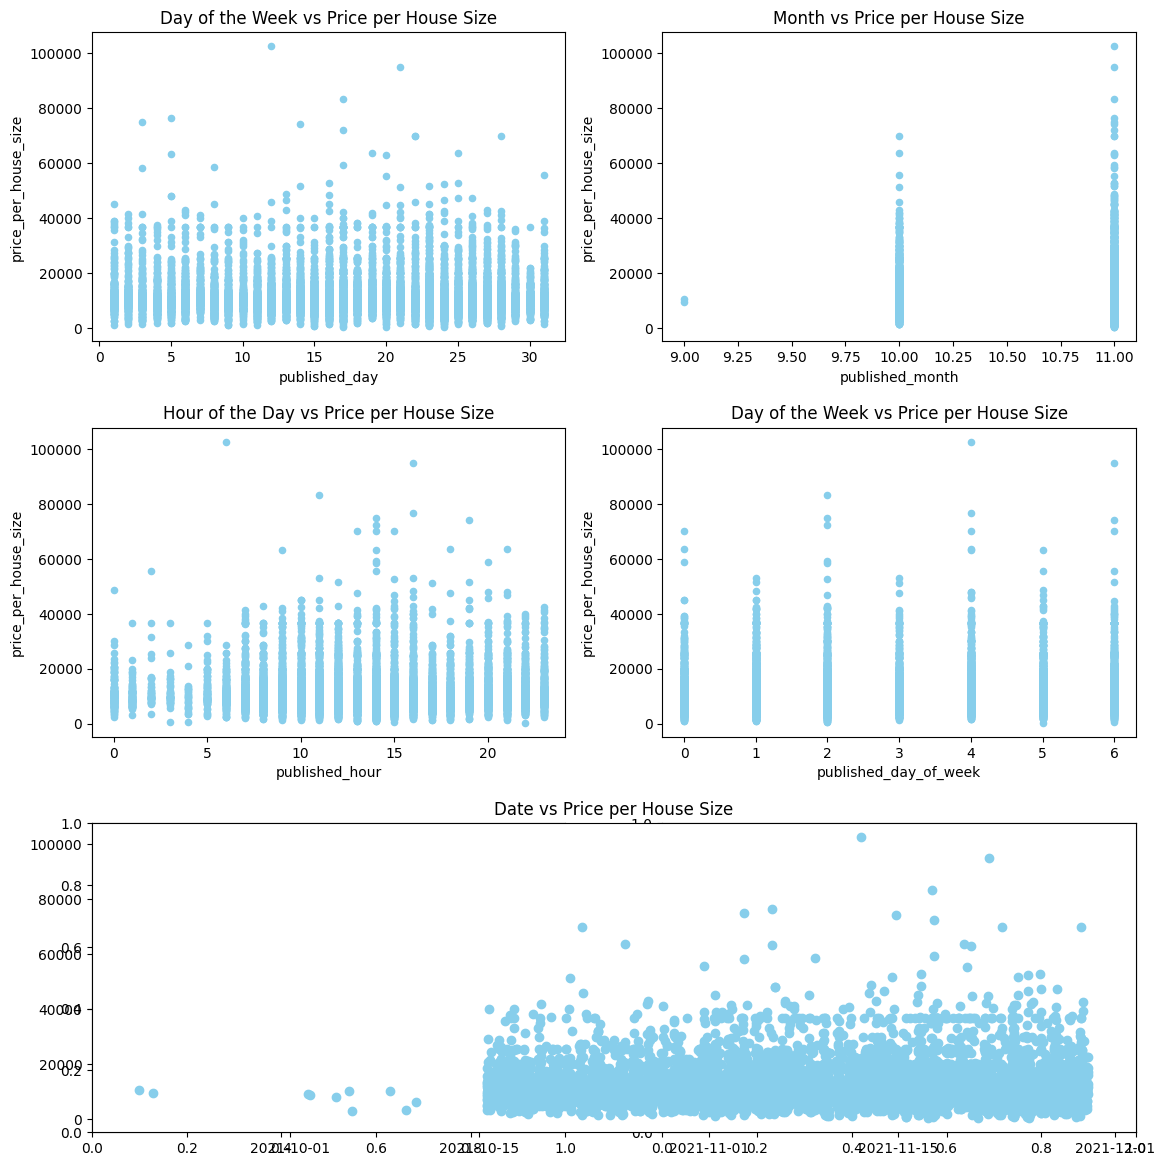

In [381]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Scatter plot 1 - published_day vs price_per_house_size
temp_df.plot(kind='scatter', x='published_day', y='price_per_house_size', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Day of the Week vs Price per House Size')

# Scatter plot 2 - published_month vs price_per_house_size
temp_df.plot(kind='scatter', x='published_month', y='price_per_house_size', ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Month vs Price per House Size')

# Scatter plot 3 - published_hour vs price_per_house_size
temp_df.plot(kind='scatter', x='published_hour', y='price_per_house_size', ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Hour of the Day vs Price per House Size')

# Scatter plot 4 - published_day_of_week vs price_per_house_size
temp_df.plot(kind='scatter', x='published_day_of_week', y='price_per_house_size', ax=axes[1, 1], color='skyblue')
axes[1, 1].set_title('Day of the Week vs Price per House Size')


# Scatter plot 5 - published_date vs price_per_house_size
plt.subplot2grid((3,2), (2,0), colspan=2)
plt.scatter(x=df['published_date'], y=temp_df['price_per_house_size'], color='skyblue')
plt.title('Date vs Price per House Size')

plt.tight_layout()
plt.show()


#### coordinate analysis

In [382]:
# get unique coordinates
unique_coordinates = temp_df[['lon', 'lat']].drop_duplicates()
print(f'coordinates {len(unique_coordinates)}/{len(df)}')

coordinates 141/12311


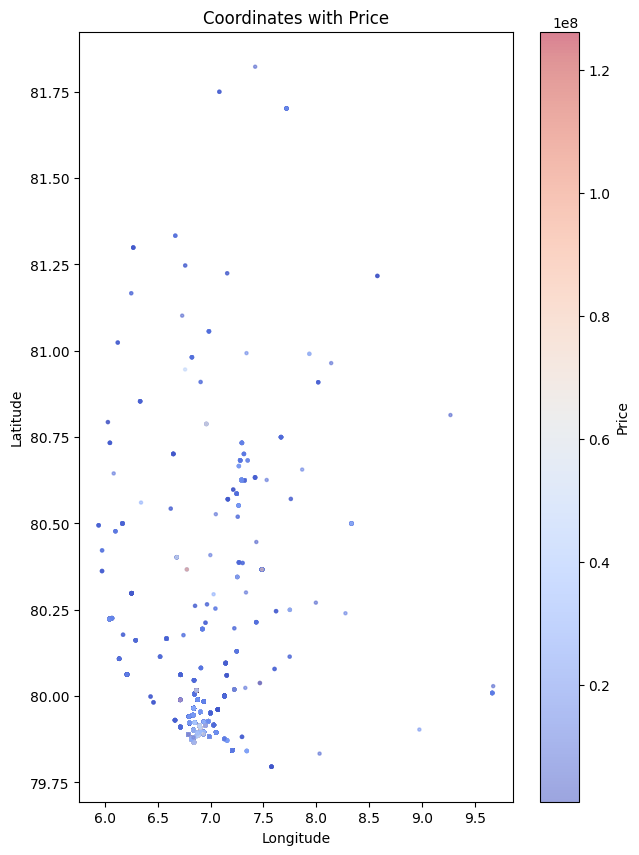

In [383]:
# Scatter plot with color representing price
plt.figure(figsize=(7, 10))
plt.scatter(temp_df['lat'], temp_df['lon'], c=temp_df['price'], cmap='coolwarm', s=5, alpha=0.5)
plt.colorbar(label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Coordinates with Price')
plt.show()


#### district and city analysis

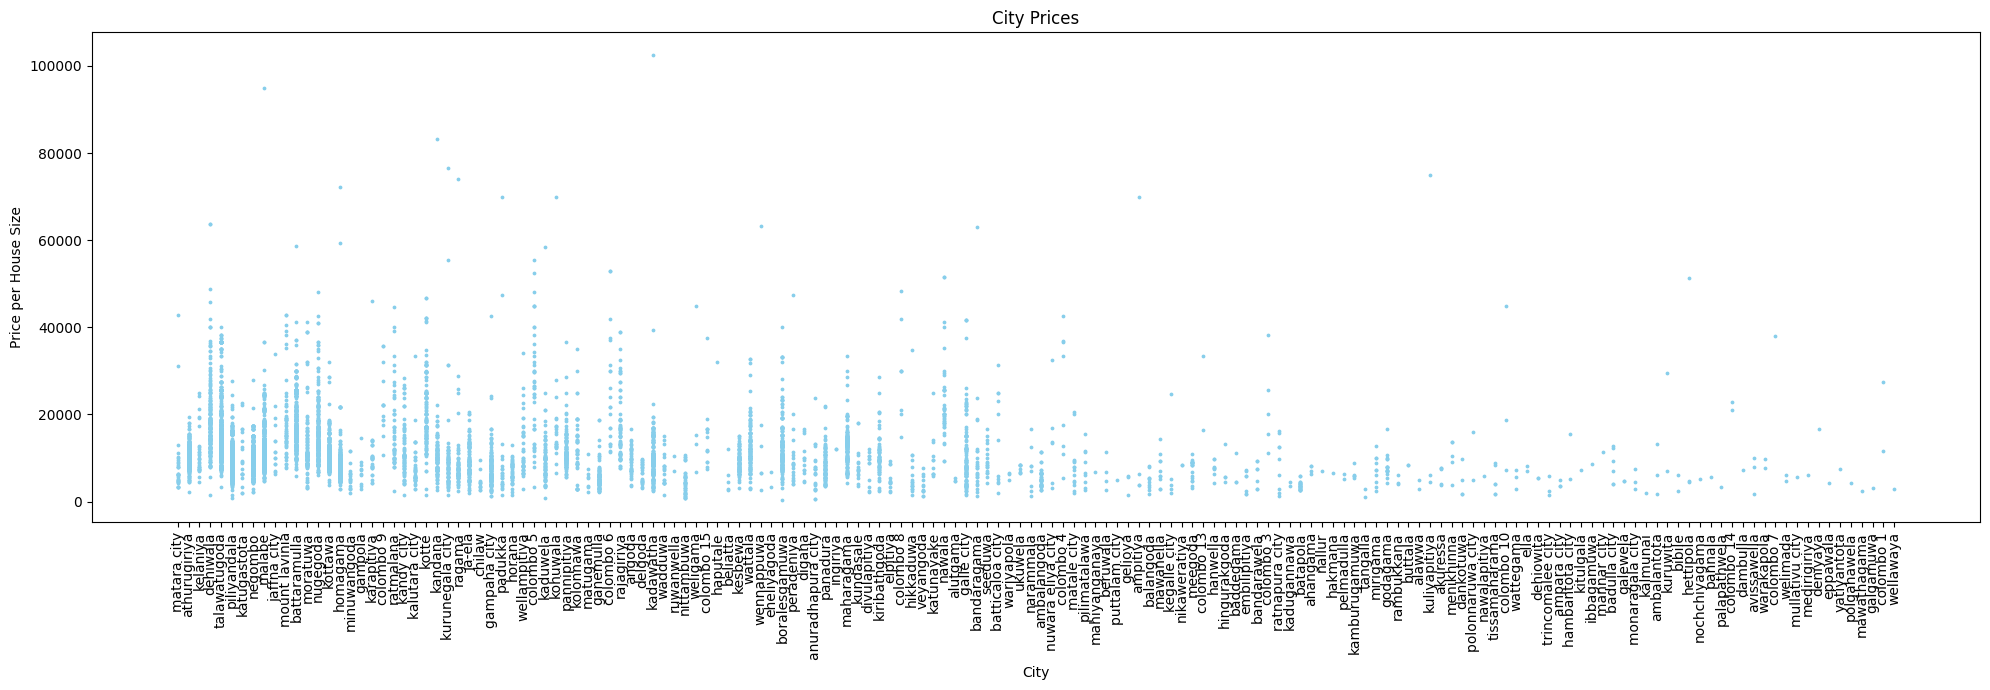

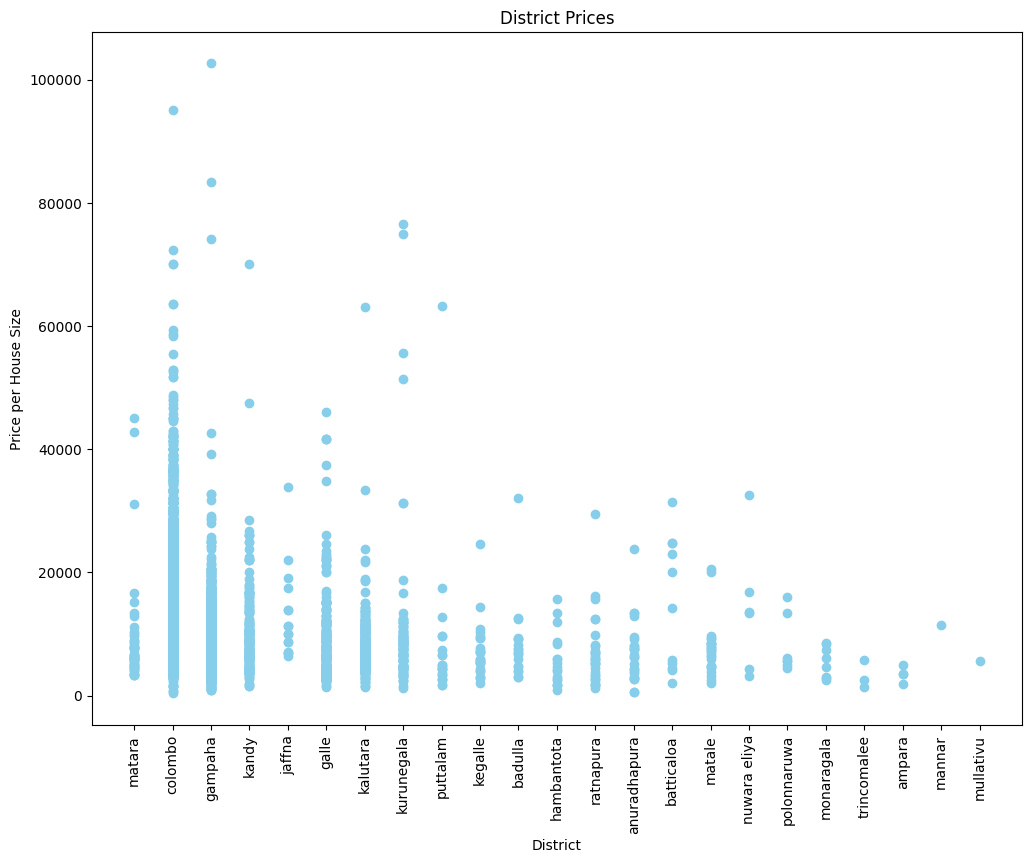

In [384]:
import matplotlib.pyplot as plt

# cities
plt.figure(figsize=(20, 7))
plt.scatter(temp_df['city'], temp_df['price_per_house_size'], color='skyblue', s=3)
plt.title('City Prices')
plt.xlabel('City')
plt.ylabel('Price per House Size')
plt.xticks(rotation=90)
plt.tight_layout()

# districts
plt.figure(figsize=(12, 9))
plt.scatter(temp_df['district'], temp_df['price_per_house_size'], color='skyblue')
plt.title('District Prices')
plt.xlabel('District')
plt.ylabel('Price per House Size')
plt.xticks(rotation=90)

# Display the chart
plt.show()


#### beds and baths analysis

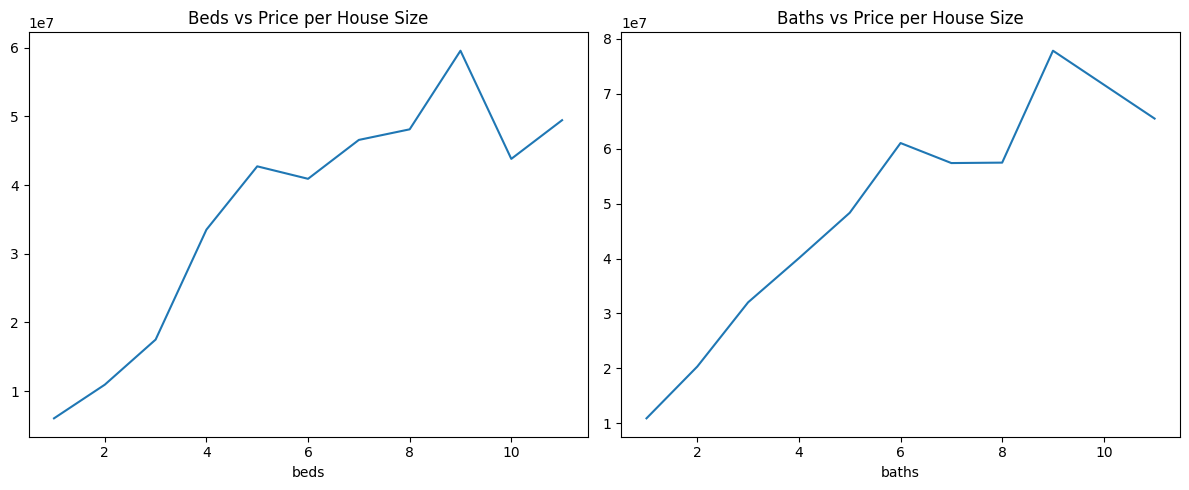

In [385]:
#beds and baths anlysis with price separately with two different plots in 2 columns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Scatter plot 1 - beds vs price_per_house_size
temp_df.groupby('beds')['price'].mean().plot(kind='line', ax=axes[0])
axes[0].set_title('Beds vs Price per House Size')

# Scatter plot 2 - baths vs price_per_house_size
temp_df.groupby('baths')['price'].mean().plot(kind='line', ax=axes[1])
axes[1].set_title('Baths vs Price per House Size')

plt.tight_layout()
plt.show()


#### house size and land size analysis

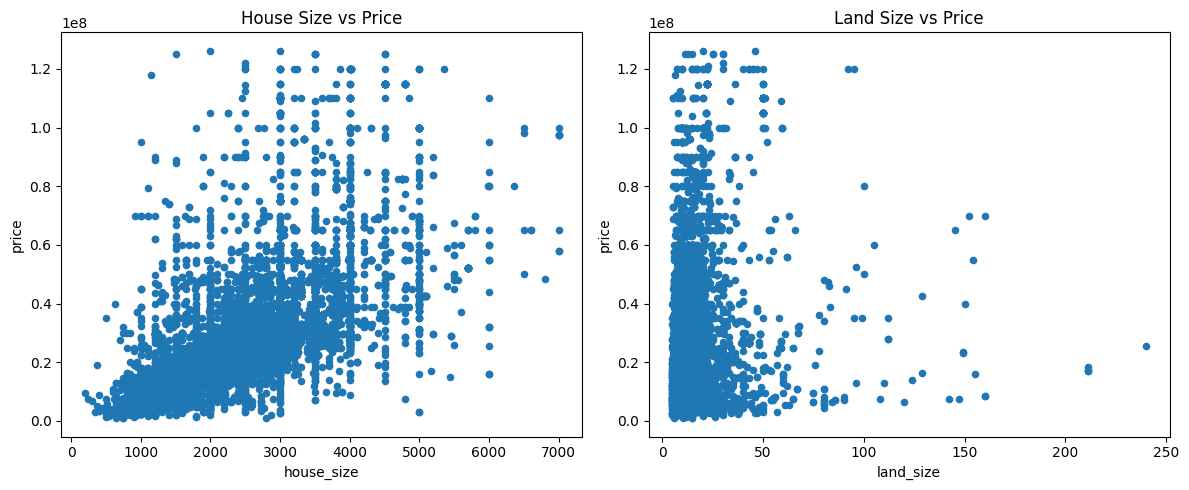

In [386]:
# house size and land size analysis with price separately with two different plots in 2 columns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Scatter plot 1 - house_size vs price_per_house_size
temp_df.plot(kind='scatter', x='house_size', y='price', ax=axes[0])
axes[0].set_title('House Size vs Price')

# Scatter plot 2 - land_size vs price_per_house_size
temp_df.plot(kind='scatter', x='land_size', y='price', ax=axes[1])
axes[1].set_title('Land Size vs Price')

plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_4668\2892632763.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_df.groupby(pd.cut(df['house_size'], bins=50))['price'].mean().plot(kind='line', ax=axes[0])
C:\Users\USER\AppData\Local\Temp\ipykernel_4668\2892632763.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_df.groupby(pd.cut(df['land_size'], bins=50))['price'].mean().plot(kind='line', ax=axes[1])


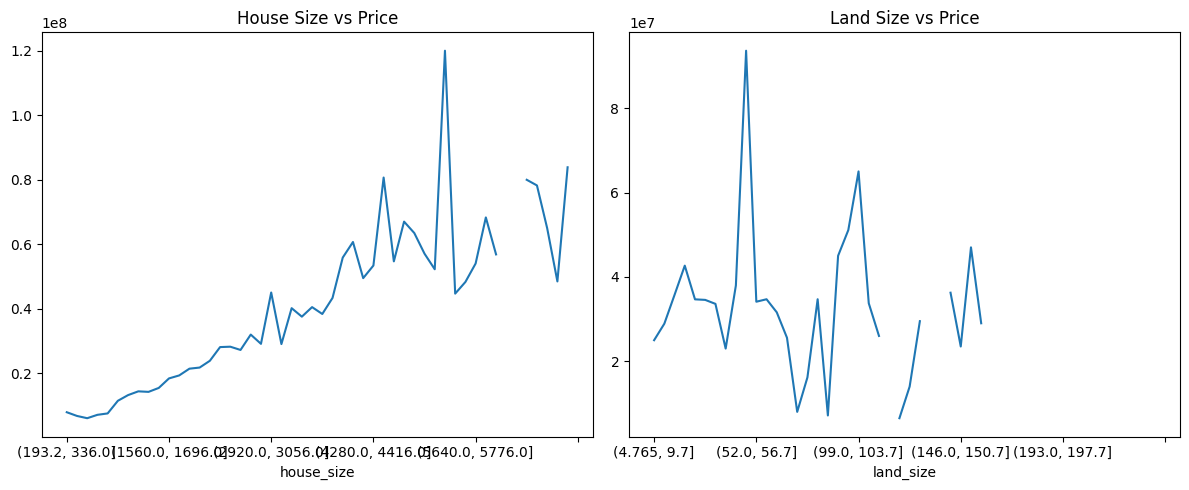

In [387]:
#groupby bins of house size and land size and plot the mean price
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Scatter plot 1 - house_size vs price_per_house_size
temp_df.groupby(pd.cut(df['house_size'], bins=50))['price'].mean().plot(kind='line', ax=axes[0])
axes[0].set_title('House Size vs Price')

# Scatter plot 2 - land_size vs price_per_house_size
temp_df.groupby(pd.cut(df['land_size'], bins=50))['price'].mean().plot(kind='line', ax=axes[1])
axes[1].set_title('Land Size vs Price')

plt.tight_layout()
plt.show()

#### Sqft per bed analysis

C:\Users\USER\AppData\Local\Temp\ipykernel_4668\2826311148.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(temp_df['sqft_per_bed'], bins=40))['price'].mean().plot(kind='line', ax=axes[1])


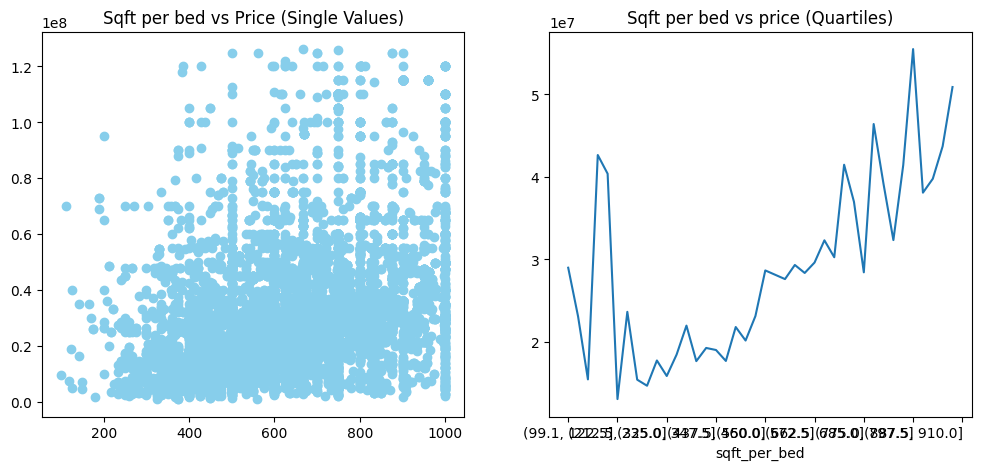

In [388]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].scatter(temp_df['sqft_per_bed'], temp_df['price'], color='skyblue')
axes[0].set_title('Sqft per bed vs Price (Single Values)')

df.groupby(pd.cut(temp_df['sqft_per_bed'], bins=40))['price'].mean().plot(kind='line', ax=axes[1])
axes[1].set_title('Sqft per bed vs price (Quartiles)')

plt.show()

#### bath per bed analysis

C:\Users\USER\AppData\Local\Temp\ipykernel_4668\2777125918.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(temp_df['baths_per_bed'], bins=10))['price'].mean().plot(kind='line', ax=axes[1])


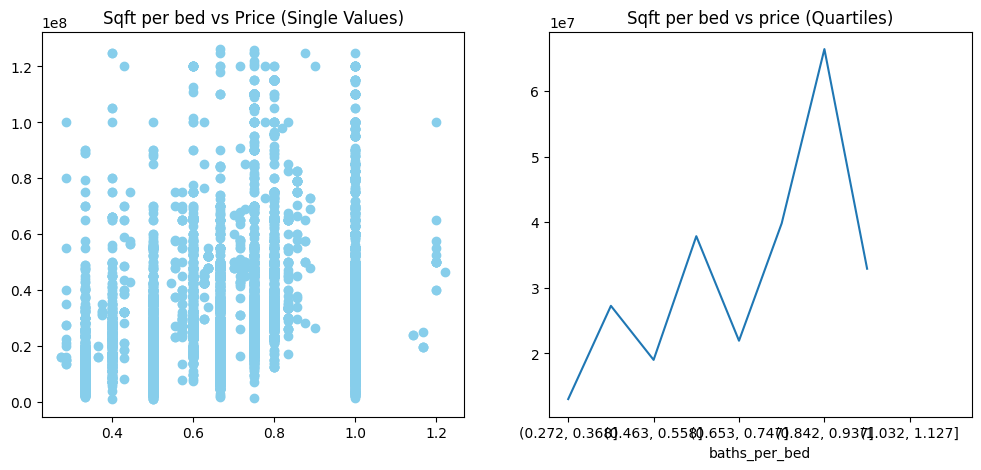

In [389]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].scatter(temp_df['baths_per_bed'], df['price'], color='skyblue')
axes[0].set_title('Sqft per bed vs Price (Single Values)')

df.groupby(pd.cut(temp_df['baths_per_bed'], bins=10))['price'].mean().plot(kind='line', ax=axes[1])
axes[1].set_title('Sqft per bed vs price (Quartiles)')

plt.show()

#### house land ratio analysis

C:\Users\USER\AppData\Local\Temp\ipykernel_4668\700794651.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(temp_df['house_land_ratio'], bins=40))['price'].mean().plot(kind='line', ax=axes[1])


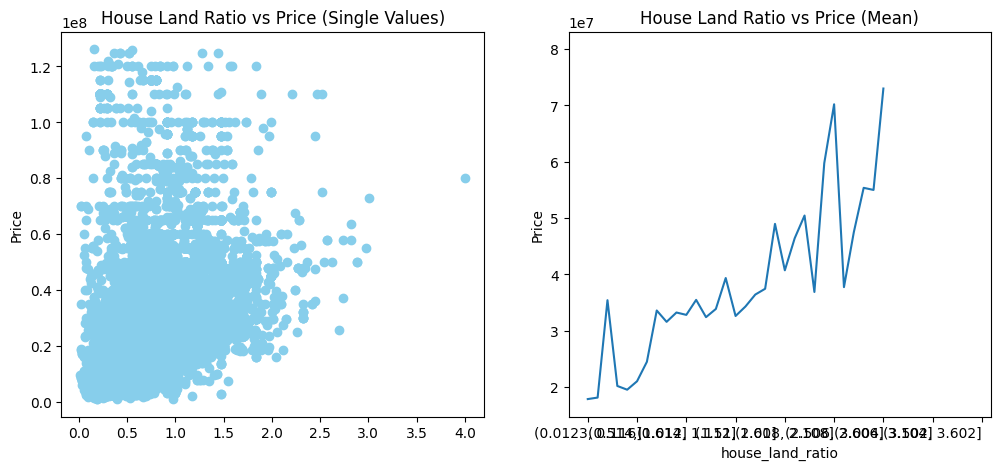

In [390]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].scatter(temp_df['house_land_ratio'], temp_df['price'], color='skyblue')
axes[0].set_title('House Land Ratio vs Price (Single Values)')
axes[0].set_ylabel('Price')

df.groupby(pd.cut(temp_df['house_land_ratio'], bins=40))['price'].mean().plot(kind='line', ax=axes[1])
# temp_df.groupby('house_land_ratio')['price'].mean().plot(kind='line', ax=axes[1])
axes[1].set_title('House Land Ratio vs Price (Mean)')
axes[1].set_ylabel('Price')

plt.show()

### Normalization

In [391]:
column_info = df.describe()
column_info

,price,baths,land_size,beds,house_size,published_date,lon,lat,sqft_per_bed,house_land_ratio,baths_per_bed
count,1.231100e+04,12311.000000,12311.000000,12311.000000,12311.00000,12311,12311.000000,12311.000000,12311.000000,12311.000000,12311.000000
mean,2.967204e+07,2.903257,12.523925,3.953294,2501.37258,2021-11-09 21:43:16.351230464,79.971505,6.913106,630.911028,0.898437,0.731586
min,9.250000e+05,1.000000,5.000000,1.000000,200.00000,2021-09-19 21:01:00,79.795675,5.941424,100.000000,0.016325,0.272727
25%,1.650000e+07,2.000000,8.000000,3.000000,1610.00000,2021-10-30 21:04:30,79.913892,6.801844,500.000000,0.561767,0.600000
50%,2.550000e+07,3.000000,10.000000,4.000000,2500.00000,2021-11-12 08:23:00,79.930510,6.877014,625.000000,0.857668,0.750000
75%,3.500000e+07,4.000000,12.850000,4.000000,3100.00000,2021-11-20 10:20:30,79.989929,6.935757,750.000000,1.204293,1.000000
max,1.262250e+08,11.000000,240.000000,11.000000,7000.00000,2021-11-29 01:35:00,81.822554,9.673491,1000.000000,4.000334,1.222222
std,2.046660e+07,1.179220,10.785057,1.193951,982.32554,NaN,0.162370,0.238914,169.443557,0.426415,0.215104


In [392]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# masks
continuous_features = (df.dtypes == np.float64) | (df.dtypes == np.int64)
discrete_features = df.dtypes == np.int8

continuous_features = continuous_features[continuous_features==True].index.tolist()
continuous_features.remove('price')
discrete_features = discrete_features[discrete_features==True].index.tolist()

df[continuous_features] = std_scaler.fit_transform(df[continuous_features])
df[discrete_features] = minmax_scaler.fit_transform(df[discrete_features])

# TODO : lat lon max min scaler

df.describe()

,price,baths,land_size,beds,house_size,published_date,lon,lat,sqft_per_bed,house_land_ratio,baths_per_bed
count,1.231100e+04,12311.000000,1.231100e+04,12311.000000,1.231100e+04,12311,1.231100e+04,1.231100e+04,1.231100e+04,1.231100e+04,1.231100e+04
mean,2.967204e+07,0.190326,1.010032e-16,0.295329,-1.431359e-16,2021-11-09 21:43:16.351230464,-3.168094e-14,-3.910842e-15,5.309880e-17,-1.061976e-16,-1.038890e-16
min,9.250000e+05,0.000000,-6.976533e-01,0.000000,-2.342875e+00,2021-09-19 21:01:00,-1.082938e+00,-4.067255e+00,-3.133389e+00,-2.068752e+00,-2.133277e+00
25%,1.650000e+07,0.100000,-4.194794e-01,0.200000,-9.074474e-01,2021-10-30 21:04:30,-3.548402e-01,-4.657212e-01,-7.726251e-01,-7.895659e-01,-6.117554e-01
50%,2.550000e+07,0.200000,-2.340301e-01,0.300000,-1.397333e-03,2021-11-12 08:23:00,-2.524885e-01,-1.510754e-01,-3.488635e-02,-9.561311e-02,8.560880e-02
75%,3.500000e+07,0.300000,3.023520e-02,0.300000,6.094230e-01,2021-11-20 10:20:30,1.134742e-01,9.481100e-02,7.028524e-01,7.173026e-01,1.247882e+00
max,1.262250e+08,1.000000,2.109264e+01,1.000000,4.579755e+00,2021-11-29 01:35:00,1.140065e+01,1.155437e+01,2.178330e+00,7.274650e+00,2.281015e+00
std,2.046660e+07,0.117922,1.000041e+00,0.119395,1.000041e+00,NaN,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00


### Encoding categorical attributes

Since all the dataset does not contain all the cities and districts in Sri Lanka, we will introduce a new category called unknown. This will enable the model to be used in cases where we do not have the city or district information.

Cities and districts with less than 10 records are also considered as unknown to avoid overfitting due to limited data.

In [393]:
# pick districts with more than 10 houses as features
district_freq = df.groupby('district')['price'].count()
district_freq = district_freq[district_freq > 10]
df.loc[~df['district'].isin(district_freq.index.tolist()), 'district'] = 'unknown'

# pick cities with more than 10 houses as features
city_freq = df.groupby('city')['price'].count()
city_freq = city_freq[city_freq > 10]
df.loc[~df['city'].isin(city_freq.index.tolist()), 'city'] = 'unknown'

# count of each city and district
print(dict(df['district'].value_counts()))
print(dict(df['city'].value_counts()))


{'colombo': 8744, 'gampaha': 2508, 'galle': 251, 'kalutara': 241, 'kandy': 185, 'kurunegala': 109, 'matara': 48, 'ratnapura': 32, 'unknown': 30, 'kegalle': 26, 'matale': 26, 'anuradhapura': 25, 'puttalam': 22, 'badulla': 19, 'hambantota': 18, 'jaffna': 16, 'batticaloa': 11}
{'piliyandala': 2309, 'malabe': 1519, 'negombo': 1282, 'talawatugoda': 924, 'kottawa': 628, 'athurugiriya': 586, 'battaramulla': 416, 'nugegoda': 313, 'unknown': 306, 'homagama': 286, 'kadawatha': 277, 'dehiwala': 212, 'maharagama': 212, 'boralesgamuwa': 197, 'gampaha city': 168, 'kotte': 141, 'wattala': 126, 'pannipitiya': 126, 'moratuwa': 124, 'ja-ela': 121, 'galle city': 121, 'kandana': 114, 'kesbewa': 98, 'ganemulla': 98, 'panadura': 96, 'kurunegala city': 83, 'kaduwela': 81, 'kandy city': 80, 'ragama': 74, 'kiribathgoda': 71, 'rajagiriya': 70, 'mount lavinia': 57, 'ratmalana': 53, 'kolonnawa': 47, 'wellampitiya': 46, 'colombo 5': 45, 'nawala': 44, 'horana': 43, 'nittambuwa': 42, 'ambalangoda': 41, 'kalutara cit

In [394]:
city_sample = df.groupby('city').sample(4, random_state=7).copy()
city_sample['city'] = 'unknown'

district_sample = df.groupby('district').sample(4, random_state=7).copy()
district_sample['district'] = 'unknown'
district_sample['city'] = 'unknown'

# add samples to dataframe
df = pd.concat([df, city_sample, district_sample], ignore_index=True)

# count of each city and district
print(dict(df['district'].value_counts()))
print(dict(df['city'].value_counts()))

# save unique cities and districts
cities = df['city'].unique()
districts = df['district'].unique()


{'colombo': 8868, 'gampaha': 2576, 'galle': 275, 'kalutara': 261, 'kandy': 206, 'kurunegala': 113, 'unknown': 98, 'matara': 53, 'ratnapura': 33, 'anuradhapura': 30, 'matale': 30, 'kegalle': 26, 'puttalam': 26, 'jaffna': 20, 'badulla': 19, 'hambantota': 18, 'batticaloa': 15}
{'piliyandala': 2309, 'malabe': 1519, 'negombo': 1282, 'talawatugoda': 924, 'unknown': 662, 'kottawa': 628, 'athurugiriya': 586, 'battaramulla': 416, 'nugegoda': 313, 'homagama': 286, 'kadawatha': 277, 'dehiwala': 212, 'maharagama': 212, 'boralesgamuwa': 197, 'gampaha city': 168, 'kotte': 141, 'wattala': 126, 'pannipitiya': 126, 'moratuwa': 124, 'ja-ela': 121, 'galle city': 121, 'kandana': 114, 'kesbewa': 98, 'ganemulla': 98, 'panadura': 96, 'kurunegala city': 83, 'kaduwela': 81, 'kandy city': 80, 'ragama': 74, 'kiribathgoda': 71, 'rajagiriya': 70, 'mount lavinia': 57, 'ratmalana': 53, 'kolonnawa': 47, 'wellampitiya': 46, 'colombo 5': 45, 'nawala': 44, 'horana': 43, 'nittambuwa': 42, 'ambalangoda': 41, 'kalutara cit

In [395]:
# make hierarchy of city and district
unique_cities_districts = df[['district', 'city']].drop_duplicates()

# to dictionary
location_hierarchy = unique_cities_districts.groupby('district')['city'].apply(list).to_dict()

location_hierarchy

{'anuradhapura': ['anuradhapura city', 'unknown'],
 'badulla': ['unknown'],
 'batticaloa': ['batticaloa city', 'unknown'],
 'colombo': ['athurugiriya',
  'dehiwala',
  'talawatugoda',
  'piliyandala',
  'malabe',
  'mount lavinia',
  'battaramulla',
  'moratuwa',
  'nugegoda',
  'kottawa',
  'homagama',
  'colombo 9',
  'ratmalana',
  'kotte',
  'padukka',
  'wellampitiya',
  'colombo 5',
  'kaduwela',
  'kohuwala',
  'pannipitiya',
  'kolonnawa',
  'colombo 6',
  'rajagiriya',
  'angoda',
  'colombo 15',
  'kesbewa',
  'boralesgamuwa',
  'maharagama',
  'unknown',
  'nawala',
  'meegoda',
  'godagama'],
 'galle': ['karapitiya',
  'elpitiya',
  'hikkaduwa',
  'galle city',
  'ambalangoda',
  'unknown',
  'batapola'],
 'gampaha': ['kelaniya',
  'negombo',
  'minuwangoda',
  'kandana',
  'ragama',
  'ja-ela',
  'gampaha city',
  'ganemulla',
  'delgoda',
  'kadawatha',
  'nittambuwa',
  'wattala',
  'divulapitiya',
  'kiribathgoda',
  'veyangoda',
  'katunayake',
  'seeduwa',
  'unknown'

In [396]:
# one hot encoding
df = pd.get_dummies(df, columns=['city'], prefix='city', prefix_sep='_')
df = pd.get_dummies(df, columns=['district'], prefix='district', prefix_sep='_')

### Training model

In [397]:
df.columns

Index(['price', 'baths', 'land_size', 'beds', 'house_size', 'published_date',
       'lon', 'lat', 'sqft_per_bed', 'house_land_ratio', 'baths_per_bed',
       'city_ambalangoda', 'city_angoda', 'city_anuradhapura city',
       'city_athurugiriya', 'city_bandaragama', 'city_batapola',
       'city_battaramulla', 'city_batticaloa city', 'city_boralesgamuwa',
       'city_chilaw', 'city_colombo 15', 'city_colombo 5', 'city_colombo 6',
       'city_colombo 9', 'city_dehiwala', 'city_delgoda', 'city_digana',
       'city_divulapitiya', 'city_elpitiya', 'city_galle city',
       'city_gampaha city', 'city_ganemulla', 'city_godagama',
       'city_hikkaduwa', 'city_homagama', 'city_horana', 'city_ja-ela',
       'city_jaffna city', 'city_kadawatha', 'city_kaduwela',
       'city_kalutara city', 'city_kandana', 'city_kandy city',
       'city_karapitiya', 'city_katugastota', 'city_katunayake',
       'city_kelaniya', 'city_kesbewa', 'city_kiribathgoda', 'city_kohuwala',
       'city_kolonnawa'

In [398]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if 'published_date' in df.columns:
    df = df.drop(columns=['published_date'])

# Split the dataset into features (X) and target variable (y)
X = df.drop('price', axis=1)
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate different regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Support Vector Regression': SVR(kernel='linear'),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
}

# Train and evaluate each model

r2_scores = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print the statistics
    print(f"Model: {model_name}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared (R2) Score: {r2}")
    print()

    r2_scores[model_name] = r2


Model: Linear Regression
Mean Absolute Error: 7321165.814917127
Mean Squared Error: 137246794796866.75
R-squared (R2) Score: 0.6776509136229372

Model: Ridge Regression
Mean Absolute Error: 7312386.388986107
Mean Squared Error: 137310828049069.33
R-squared (R2) Score: 0.6775005198714781



c:\Users\USER\Documents\SLIIT\fdm mini project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.056e+17, tolerance: 4.260e+14
  model = cd_fast.enet_coordinate_descent(


Model: Lasso Regression
Mean Absolute Error: 7320830.269021869
Mean Squared Error: 137244025602111.7
R-squared (R2) Score: 0.6776574175810123

Model: Elastic Net
Mean Absolute Error: 9515226.048839657
Mean Squared Error: 228421142044039.88
R-squared (R2) Score: 0.46351135881839556

Model: Support Vector Regression
Mean Absolute Error: 13698322.384590397
Mean Squared Error: 441857000520524.5
R-squared (R2) Score: -0.03778161550445214

Model: Decision Tree Regressor
Mean Absolute Error: 3749133.301208241
Mean Squared Error: 104602487574186.56
R-squared (R2) Score: 0.7543220127492779

Model: Random Forest Regressor
Mean Absolute Error: 3394999.625428446
Mean Squared Error: 69623362693388.91
R-squared (R2) Score: 0.8364768562505975

Model: Gradient Boosting Regressor
Mean Absolute Error: 5784839.216992416
Mean Squared Error: 97284941535876.14
R-squared (R2) Score: 0.7715086019403962



### Export content

In [399]:
import pickle

# get best model
best_model = models[max(r2_scores, key=r2_scores.get)]

# save model
with open('./app/exports/model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# save std_scaler
with open('./app/exports/std_scaler.pkl', 'wb') as file:
    pickle.dump([continuous_features, std_scaler], file)

# save minmax_scaler
with open('./app/exports/minmax_scaler.pkl', 'wb') as file:
    pickle.dump([discrete_features, minmax_scaler], file)

# save column order
with open('./app/exports/column_order.pkl', 'wb') as file:
    pickle.dump(X_train.columns.tolist(), file)

# save column info
with open('./app/exports/column_info.pkl', 'wb') as file:
    pickle.dump(column_info, file)

# save location hierarchy
with open('./app/exports/location_hierarchy.pkl', 'wb') as file:
    pickle.dump(location_hierarchy, file)